In [4]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df = pd.read_csv("./data/RegulatingBalancePowerdata.csv", sep=";")
df.head()

,HourUTC,HourDK,PriceArea,mFRRUpActBal,mFRRDownActBal,mFRRUpActSpec,mFRRDownActSpec,ImbalanceMWh,ImbalancePriceEUR,ImbalancePriceDKK,BalancingPowerPriceUpEUR,BalancingPowerPriceUpDKK,BalancingPowerPriceDownEUR,BalancingPowerPriceDownDKK
0,2025-03-04 11:00:00,2025-03-04 12:00:00,DK1,"0,000000","97,500000","0,000000","0,000000","-273,000000","-6,700000","-49,980000","4,000000",NaN,"-6,700000",NaN
1,2025-03-04 10:00:00,2025-03-04 11:00:00,DK1,"0,000000","124,000000","0,000000","0,000000","-198,000000","-1,350000","-10,070000","13,260000",NaN,"-1,350000",NaN
2,2025-03-04 09:00:00,2025-03-04 10:00:00,DK1,"0,000000","35,000000","0,000000","0,000000","-48,000000","-1,130000","-8,430000","25,299999",NaN,"-1,130000",NaN
3,2025-03-04 08:00:00,2025-03-04 09:00:00,DK1,"0,000000","0,000000","0,000000","0,000000","-44,000000","61,230000","456,709991","61,230000",NaN,"61,230000",NaN
4,2025-03-04 07:00:00,2025-03-04 08:00:00,DK1,"222,000000","0,000000","0,000000","0,000000","-63,000000","402,299988","3000,760010","402,299988",NaN,"62,849998",NaN


In [5]:
TRAIN_DAYS= 300 

df = df[['HourDK', 'ImbalancePriceEUR' ]]
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df[(df['HourDK'] >= '2023-01-01') & (df['HourDK'] <= '2023-12-31')]
df = df.iloc[::-1]
df['item_id'] = 'electricity_price'
df['ImbalancePriceEUR'] = df['ImbalancePriceEUR'].str.replace(',', '.').astype(float)
df_test = df.copy()
df = df.iloc[:TRAIN_DAYS*24 - 1]
df_test = df_test.iloc[((TRAIN_DAYS-5)*24) -1:(TRAIN_DAYS+1)*24 -1]
df.head()


,HourDK,ImbalancePriceEUR,item_id
19044,2023-01-01 00:00:00,-6.72,electricity_price
19043,2023-01-01 01:00:00,1.38,electricity_price
19042,2023-01-01 02:00:00,-6.00,electricity_price
19041,2023-01-01 03:00:00,-6.00,electricity_price
19040,2023-01-01 04:00:00,-6.00,electricity_price


In [6]:

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="HourDK",
)
test_data = TimeSeriesDataFrame.from_data_frame(
    df_test,
    id_column="item_id",
    timestamp_column="HourDK",
)

test_data.head()

ImbalancePriceEUR
item_id           timestamp                             
electricity_price 2023-10-23 00:00:00          99.459999
                  2023-10-23 01:00:00         127.309998
                  2023-10-23 02:00:00          42.880001
                  2023-10-23 03:00:00          67.139999
                  2023-10-23 04:00:00          40.000000

In [4]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    path="autogluon-m4-hourly",
    target="ImbalancePriceEUR",
    eval_metric="MASE",
    freq="H",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=1800,
)

c:\energy_price_forecasting\Lib\site-packages\autogluon\timeseries\predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to 'c:\energy_price_forecasting\autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       3.19 GB / 15.73 GB (20.3%)
Disk Space Avail:   274.40 GB / 456.62 GB (60.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.

In [5]:
predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2  \
item_id           timestamp                                              
electricity_price 2023-10-28 00:00:00  91.540237  80.719055  84.878304   
                  2023-10-28 01:00:00  88.079498  74.126251  79.624245   
                  2023-10-28 02:00:00  86.387314  70.115433  76.626686   
                  2023-10-28 03:00:00  85.219482  68.129242  74.814514   
                  2023-10-28 04:00:00  84.553986  65.787918  73.027672   

                                             0.3        0.4        0.5  \
item_id           timestamp                                              
electricity_price 2023-10-28 00:00:00  87.729553  89.524475  91.540237   
                  2023-10-28 01:00:00  83.187866  85.596848  88.079498   
                  2023-10-28 02:00:00  80.642807  83.551674  86.387314   
                  2023-10-28 03:00:00  79.097412  82.220963  85.219482   
                  2023-10-28 04:00:00  77.686081  81.218658  84.553986   

                                             0.6        0.7        0.8  \
item_id           timestamp                                              
electricity_price 2023-10-28 00:00:00  93.170990  95.393883  97.992905   
                  2023-10-28 01:00:00  90.209366  92.909866  96.138855   
                  2023-10-28 02:00:00  88.948776  92.009674  95.710083   
                  2023-10-28 03:00:00  87.886017  91.060440  94.909065   
                  2023-10-28 04:00:00  87.576050  91.087616  95.437393   

                                              0.9  
item_id           timestamp                        
electricity_price 2023-10-28 00:00:00  102.012077  
                  2023-10-28 01:00:00  101.168694  
                  2023-10-28 02:00:00  101.650665  
                  2023-10-28 03:00:00  101.295227  
                  2023-10-28 04:00:00  102.543518

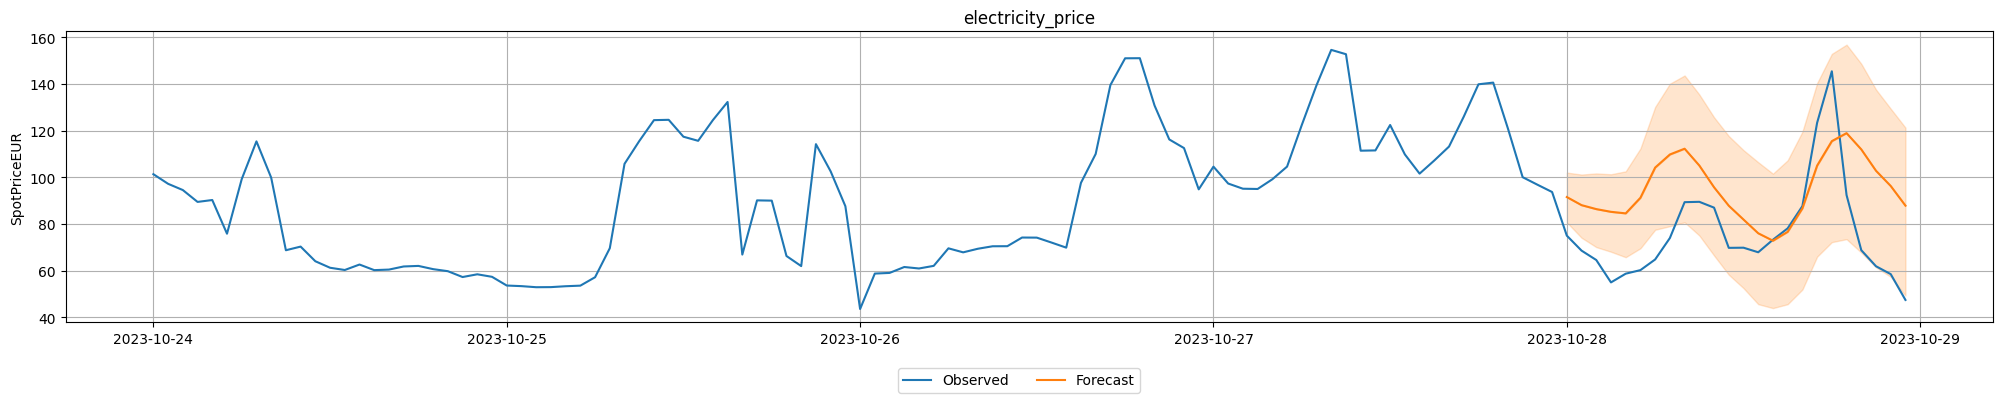

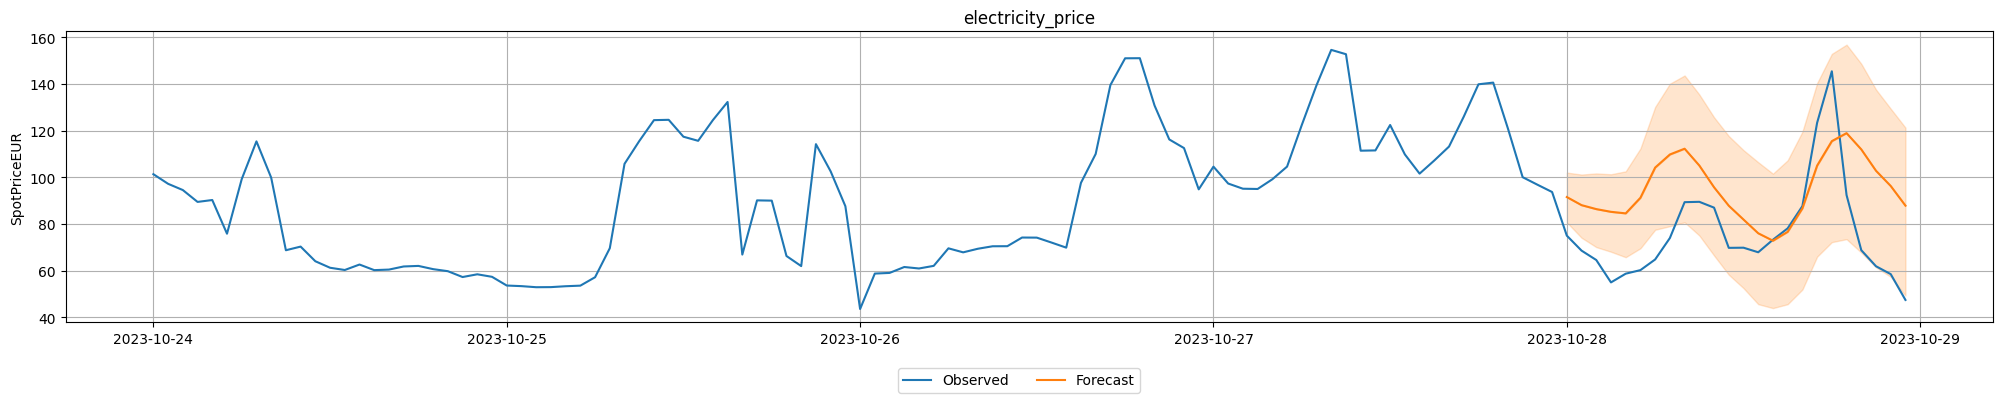

In [6]:
import matplotlib.pyplot as plt
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)

In [7]:
# The test score is computed using the last
# prediction_length=24 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TemporalFusionTransformer,-0.422439,-0.509693,0.088219,0.017226,313.600100,8
1,DynamicOptimizedTheta,-0.546329,-0.943736,27.230993,25.200706,35.858495,5
2,RecursiveTabular,-0.588725,-0.948103,1.439877,1.848197,20.254993,2
3,AutoETS,-0.624635,-0.760210,6.130533,1.475595,1.522684,6
4,DirectTabular,-0.663559,-1.049254,0.205291,0.289290,5.977360,3
5,NPTS,-0.719136,-0.898165,2.096108,5.055001,3.845114,4
6,WeightedEnsemble,-0.777511,-0.476279,1.059165,2.964623,0.794372,12
7,ChronosZeroShot[bolt_base],-0.785675,-0.543244,0.930984,2.924318,19.026725,7
8,PatchTST,-0.855665,-0.588400,0.062468,0.020692,168.329278,10
9,TiDE,-0.868080,-0.584469,0.037962,0.023079,428.943303,11


data with frequency 'None' has been resampled to frequency 'h'.


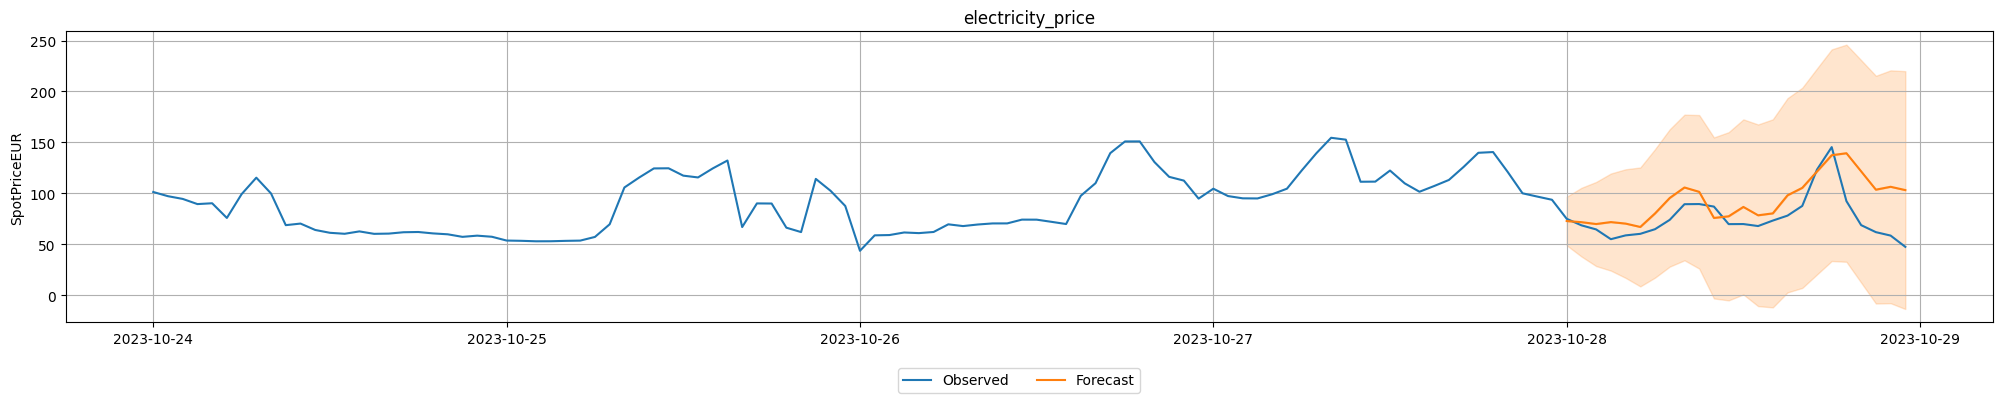

In [8]:
predictions = predictor.predict(train_data, model='RecursiveTabular')
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)
